In [1]:
import sys
sys.path.insert(0, '..')
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
from models import periodic_shape_sampler_xyz
from models import super_shape_sampler
from models import super_shape
from models import model_utils
import utils
from losses import custom_chamfer_loss
import numpy as np
import random
import tqdm
from collections import defaultdict
from torch.autograd import Variable
import torch.optim as optim
import pickle

In [2]:
seed = 0
random.seed(seed)  
np.random.seed(seed)  
# PyTorch のRNGを初期化  
torch.manual_seed(seed)

In [14]:
EPS = 1e-7
m = 4
n = 6
batch = 10
learning_rate = .01
iters = 1000
dim = 2
train_theta_sample_num = 100
points_sample_num = 100
train_grid_sample_num = 40

device_type = 'cuda:2'
#device_type = 'cpu'
train_periodic_after_abstraction = True

periodicnet = train_periodic_after_abstraction
device = torch.device(device_type)

if periodicnet:
    ocoef = 10.
    ccoef = 1.
else:
    ocoef = 1.
    ccoef = 1.

overlap_reg_coef = 1.

# points_num, dim
points = np.stack(pickle.load(open('/home/mil/kawana/workspace/superquadric_parsing/2.pkl', 'rb')), axis=-1)
all_points_sample_num = points.shape[0]

# grid_points_num, dim
x, y, sgn = pickle.load(open('/home/mil/kawana/workspace/superquadric_parsing/2_std.pkl', 'rb'))
all_grid_sample_num = len(sgn)

def get_target_sample():
    index = random.sample(range(all_grid_sample_num), batch * train_grid_sample_num ** dim)
    train_x = x[index]
    train_y = y[index]
    train_x = torch.tensor(train_x, device=device).float()
    train_y = torch.tensor(train_y, device=device).float()
    target_coord = torch.stack([train_x, train_y], axis=1).view(batch, -1, dim)

    train_sgn = sgn[index]
    target_sgn = torch.tensor(train_sgn, device=device).float().view(batch, -1)

    points_index = random.sample(range(all_points_sample_num), batch * points_sample_num)
    target_points = points[points_index, :]
    target_points = torch.tensor(target_points, device=device).view(batch, -1, dim)

    return target_points, target_coord, target_sgn


if train_periodic_after_abstraction:
    primitive.eval()
else:
    primitive = super_shape.SuperShapes(m, n, quadrics=True, train_ab=False)
    primitive.to(device)


if periodicnet or train_periodic_after_abstraction:
    print('Train periodic net')
    sampler = periodic_shape_sampler_xyz.PeriodicShapeSamplerXYZ(points_sample_num, m, n, factor=16)
    optimizer = optim.Adam(sampler.parameters(), lr=learning_rate)
else:
    print('Train super shape')
    sampler = super_shape_sampler.SuperShapeSampler(m, n)
    optimizer = optim.Adam(primitive.parameters(), lr=learning_rate)

sampler.to(device)
torch.autograd.set_detect_anomaly(True)

loss_log = []
for idx in tqdm.tqdm(range(iters)):
    optimizer.zero_grad()

    # Ensure polar coordinate samples are closed at 0 and 2 pi.
    thetas = utils.sample_spherical_angles(batch=batch, sample_num=train_theta_sample_num, sampling='uniform', device=device)

    target_points, target_coord, target_sgn = get_target_sample()

    kwargs = {
        'thetas': thetas,
        'coord': target_coord
    }
    if periodicnet:
        kwargs['points'] = target_points

    param = primitive()
    #print(param['m_vector'].device)
    prd_points, prd_mask, prd_tsd = sampler(param, **kwargs)
    prd_sgn = model_utils.convert_tsd_range_to_zero_to_one(prd_tsd).sum(1)

    overlap_reg = (nn.functional.relu(prd_sgn - 1.2).abs()).mean()

    oloss = nn.functional.binary_cross_entropy_with_logits(prd_sgn.clamp(min=1e-7), target_sgn)

    closs = custom_chamfer_loss.custom_chamfer_loss(prd_points, target_points, surface_mask=prd_mask, prob=None)

    reg = overlap_reg * overlap_reg_coef
    loss = closs * ccoef + oloss * ocoef + reg

    print(closs.item(), reg.item(), loss.item(), oloss.item(), reg.item())
    loss_log.append(closs.detach().cpu().numpy())
    loss.backward()
    optimizer.step()

primitive.eval()
sampler.eval()



65/1000 [04:40<00:42,  3.18it/s]0.07467403262853622 0.03879439830780029 6.564273357391357 0.6450804471969604 0.03879439830780029
100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s]0.07842392474412918 0.0416225902736187 6.551921844482422 0.6431875228881836 0.0416225902736187



PeriodicShapeSamplerXYZ(
  (encoder): PointNet(
    (conv1): Conv1d(2, 4, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(4, 8, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
    (lin): Linear(in_features=8, out_features=8, bias=True)
    (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (decoder): Sequential(
    (0): PrimitiveWiseLinear(
      (main): Sequential(
        (0): Conv1d(66, 24, kernel_size=(1,), stride=(1,), groups=6)
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (1): PrimitiveWiseLinear(
      (main): Sequential(
        (0): Conv1d(24,

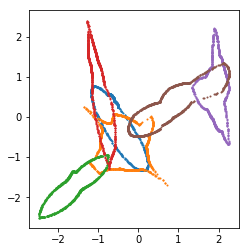

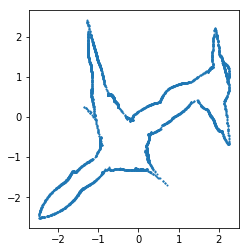

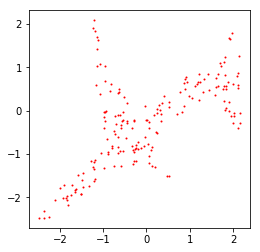

In [15]:
from visualize import plot
points_list = [prd_points]
fig = plt.figure()
for idx, points in enumerate(points_list):
    g = fig.add_subplot(1, len(points_list), idx+1)
    plot.plot_primitive_point_cloud_2d(g, points)

surface_points1 = sampler.extract_super_shapes_surface_point(prd_points[0, ...].unsqueeze(0), primitive(), points=target_points[0, ...].unsqueeze(0))
surafce_points_list = [surface_points1]
fig = plt.figure()
for idx, surface_points in enumerate(surafce_points_list):
    g = fig.add_subplot(1, len(surafce_points_list), idx+1)
    plot.plot_primitive_point_cloud_2d(g, surface_points)

tsd_list = [prd_tsd]
fig = plt.figure()
for idx, tsd in enumerate(tsd_list):
    g = fig.add_subplot(1, len(tsd_list), idx+1)
    plot.draw_primitive_inside_2d(g, tsd, target_coord)

